In [1]:
%matplotlib inline
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.fftpack
from scipy.fftpack import fft, ifft, fftshift
from scipy.signal import fftconvolve, convolve
from scipy.linalg import toeplitz, lstsq
from scipy.optimize import minimize
import math
import wavio
import sys
import time

In [2]:
def make_H(h, kn):
    '''Create a toeplitz matrix based on h vector extended to kn samples'''
    kn = max( h.shape[0], kn )
    h_ = np.append(h, np.zeros(kn-h.shape[0]))
    H = toeplitz(h_, np.zeros(h_.shape[0]))
    H_tail = toeplitz(np.zeros(kn), h_[-1::-1])[1:]
    return np.append(H, H_tail, axis=0)

In [3]:
# Make a fake room response.
hn = 1024
h = np.zeros(hn)
h[0],h[2],h[5],h[10],h[11], h[120],h[130],h[200],h[300],h[500],h[700],h[1000] = [1,-0.2, 0.3, -0.3,0.1, 0.584,-0.1,0.35,-0.713,0.123,-0.08651,0.3516]

# The length of the inverse filter.
kn = 2048

# Vector with the delta impulse.
delta = np.zeros(kn*2-1)
delta[hn-1] = 1

===== 12.140 secs =====


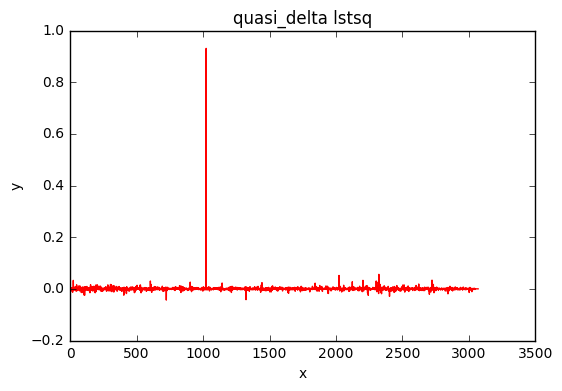

In [6]:
# Compute an inverse filter by optimizing a linear system equation:
H = make_H(h, kn)
start_time = time.time()
inverse = lstsq(H, delta)[0]
print("===== {:.3f} secs =====".format(time.time() - start_time))
figure()
plot(fftconvolve(inverse,h), 'r')
xlabel('x')
ylabel('y')
title('quasi_delta lstsq')
show()

In [9]:
# Precompute all stuff we'll need during gradient computations:
def zeros_extend(x, n):
    '''Extends x up to n samples by padding zeros'''
    return np.append(x, np.zeros(n- x.shape[0]))

h_ = np.append( h, np.zeros(kn-h.shape[0]))
H = make_H(h, kn)
H_delta = np.matmul(H.T, delta)
H_sqr = np.matmul(H.T, H)

FDelta = fft(delta)
he = zeros_extend(h_, kn*2-1)
FH_ = fft(he)
FH_revers = fft(zeros_extend(h_[-1::-1], kn*2-1))

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


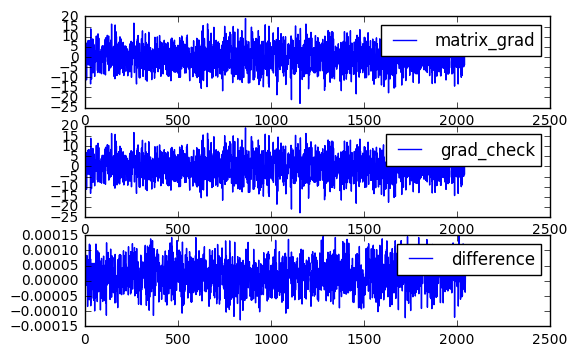

In [11]:
# Here is several functions for computin the gradient of error function.

def matrix_grad(k):
    '''Calculate gradient with single matrix multiplication'''
    return (np.matmul(H_sqr, k)- H_delta)

def conv_grad(k):
    '''Calculate gradient with convolutions'''
    d = delta - fftconvolve(h_, k0)
    d2 = -fftconvolve(h_[-1::-1], d)[k0.shape[0]-1:d.shape[0]]
    return d2

def fft_grad(k):
    '''Calculate the gradient using convulation theorem'''
    D = FDelta - FH_ * fft(zeros_extend(k, kn*2-1))
    D2 = FH_revers * D
    d2 = -ifft(D2)[k.shape[0]-1:]
    return d2

def E(x):
    '''Target function for gradient check'''
    e = (delta-fftconvolve(x,h_))
    return np.matmul(e.T, e)

def grad_check(x, f):
    '''Compute gradient by finite difference approximation in order to check it.'''
    x_d = x
    y0 = f(x)
    grad = np.zeros_like(x_d)
    dstep = 1e-8
    for i in range(x_d.shape[0]):
        x_d[i] += dstep
        grad[i] = (f(x_d)-y0)/dstep
        x_d[i] -= dstep
    
    return grad

# Here we check different functions of gradient computation in order to check those correctness.
k0 = np.random.randn(kn)
g = fft_grad(k0)*2
g_check = grad_check(k0, E)
figure()
subplot(311)
lgnd = plot(g, label="matrix_grad")
legend(handles=lgnd)
subplot(312)
lgnd = plot(g_check, label="grad_check")
legend(handles=lgnd)
subplot(313)
lgnd = plot(g[:g_check.shape[0]] - g_check, label="difference")
legend(handles=lgnd)
show()

===== 166.83216285705566 =====


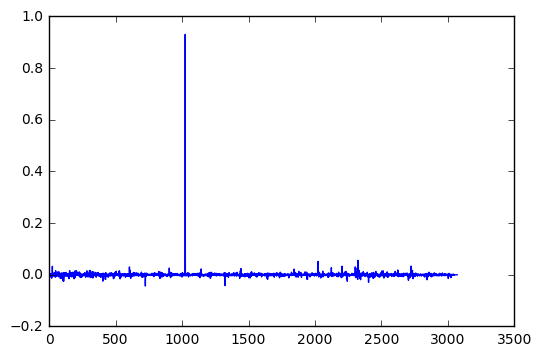

In [48]:
# Computing quasi delta impulse by minimizing error function.
# !!!Warning!!! This code unfortunately computes for a long time! (Several minutes)
start_time = time.time()
res = minimize(E, k0, method='BFGS', jac=matrix_grad)
print("===== {:.3f} =====".format(time.time() - start_time))
# print(res.x.shape)
figure()
# plot(fftconvolve(inverse,h))
plot(fftconvolve(res.x,h))
show()
